<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
<b>Phase Curve of Solar System Objects</b> <br>
Contact authors: Yumi Choi and Christina Williams<br>
Last verified to run: 2023-09-24 <br>
LSST Science Piplines version: Weekly 2023_35 <br>
Container Size: medium <br>
Targeted learning level: advanced <br>

**Description:** Explicitly investigate the derivation of phase curves for Main Belt asteroids.

**Skills:** Use the TAP service and ADQL to access the DP0.3 tables. Join information from multiple DP0.3 tables. Derive phase curves using three different models.

**LSST Data Products:** TAP tables dp03_catalogs_10yr.SSObject, dp03_catalogs_10yr.MPCORB, dp03_catalogs_10yr.DiaSource, dp03_catalogs_10yr.SSSource

**Packages:** lsst.rsp.get_tap_service

**Credit:**
Inspired by a jupyter notebook developed by Queen's University Belfast Planet Lab (including Brian Rogers, Niall McElroy, and Meg Schwamb). Standalone functions for phase curve fitting were developed by Pedro Bernardinelli. References: <a href="https://ui.adsabs.harvard.edu/abs/2010Icar..209..542M/abstract">Muinonen et al. (2010)</a> and <a href="http://astronotes.co.uk/blog/2018/05/28/determining-the-h-g-parameters-of-atlas-asteroid-phase-curves.html">David Young's webpage.</a> Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.

**Get Support:** Find DP0.3-related documentation and resources at <a href="https://dp0-3.lsst.io">dp0-3.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

This notebook targets for an advanced user who is interested in understanding phase curve fitting in DP0.3 in detail. This notebook will explicitly explore three different functional forms that are broadly used for modeling a phase curve of an asteroid, and make a comparison with the `H` and `G12` parameters stored in the `SSObject` table. Please refer to the Introduction of the companion tutorial notebook 04a for definition of the phase curve. Only the most relevent parts to this tutorial are repeated here.

Modeling the phase curve (reduced magnitude $H(α)$ as a function of phase angle $α$) enables measurement of the absolute magnitude, $H$, defined as the brightness at 0 phase angle. The functional form can depend on the data quality and type of object targeted. This tutorial will explore three functional forms that are relevant for understanding the DP0.3 data products: `HG_model`, `HG1G2_model`, and `HG12_model`. The `HG_model` is the simplest model, and has the form:

$$H(α)=H−2.5log_{10}[(1−G)Φ_1(α)+GΦ_2(α)],$$

where $Φ_n$ are basis functions (which allow for one to model non-linearity in the data, but maintain linearity in the fitted parameters). $Φ_n$ are normalized to unity at α=0 deg. This model provides a best fit for the slope parameter $G$ (from which surface properties can then be derived) and the absolute magnitude $H$. $H$(α) is the reduced magnitude at a given phase angle α if measured at 1 au away from both Earth and from the Sun (i.e. unit topocentric and heliocentric distance). The `HG_model` $G$ and $H$ values are stored in the `dp03_catalogs_10yr.MPCORB` table. For further info on the `HG_model`, see [Bowell et al. 1989](https://ui.adsabs.harvard.edu/abs/1989aste.conf..524B/abstract). 

To better accommodate various observational effects (e.g., photometric quality, incomplete phase angle sampling) the more sophisticated `HG1G2_model` (a linear three-parameter function) and its nonlinear two-parameter version `HG12_model` were developed (see [Muinonen et al. 2010](https://ui.adsabs.harvard.edu/abs/2010Icar..209..542M/abstract)). The `HG1G2_model` has the form

$$H(α)=H−2.5log_{10}[G_1Φ_1(α)+G_2Φ_2(α) + (1-G_1-G_2)Φ3(α)],$$

which now has three free parameters, $H$, $G_1$ and $G_2$. However, a third representation, the `HG12_model`, is generally very effective for deriving reliable values of absolute magnitude when the phase angle sampling is not optimal (e.g., poor phase angle coverage at a range of phase angle). Thus, the LSST data products will compute estimated parameters of the `HG12_model` and this will be the focus of this tutorial. The `HG12_model` expresses the $G_1$ and $G_2$ parameters as a piecewise linear function of a single parameter, $G_{12}$, 

for $G_{12}$ > 0.2,
$$G_1 = 0.9529\times G_{12} + 0.02162,$$
$$G_2 = -0.6125\times G_{12} + 0.5572,$$
for $G_{12}$ < 0.2,
$$G_1 = 0.7527\times G_{12} + 0.06164,$$
$$G_2 = -0.9612\times G_{12} + 0.6270.$$

This notebook presents an illustrative example of deriving the phase curve of Main Belt asteroids using DP0.3 simulated catalogs. In Section 2, we will retrieve the necessary data from the DP0.3 database. Section 3 will delve into manual phase curve fitting for a single object using three different parametrizations of the phase curve model. In Section 4, we will then compare this manual fitting to the automated phase curve fitting carried out as part of the LSST data products, which are available inthe SSObject table.

### 1.1 Package Imports

The [matplotlib](https://matplotlib.org/) (and especially sublibrary `matplotlib.pyplot`), [numpy](http://www.numpy.org/), and [scipy](https://scipy.org/) libraries are widely used Python libraries for plotting and scientific computing, and model fitting.

The `lsst.rsp` package provides access to the Table Access Protocol (TAP) service for queries to the DP0 catalogs.

The [pandas](https://pandas.pydata.org/) package enables table and dataset manipulation.


In [1]:
# general python packages
import numpy as np
from scipy.interpolate import CubicSpline
from scipy.optimize import leastsq
import pandas as pd
import matplotlib.pyplot as plt

# LSST package for TAP queries
from lsst.rsp import get_tap_service

### 1.2 Define Functions and Parameters

#### 1.2.1 Set up some plotting defaults

In [2]:
plt.style.use('tableau-colorblind10')
params = {'axes.labelsize': 15,
          'font.size': 15,
          'legend.fontsize': 12}
plt.rcParams.update(params)

Set up colors and plot symbols corresponding to the $g,r,i,z$ bands since there are no $u$ and $y$ band data in the DP0.3 catalogs. These colors are the same as those used for $g,r,i,z$ bands in Dark Energy Survey (DES) publications, and are defined in <a href="https://github.com/DarkEnergySurvey/descolors">this github repository</a>.

In [3]:
filts = ['g', 'r', 'i', 'z']
filter_colors = {'g': '#008060', 'r': '#ff4000', 'i': '#850000', 'z': '#6600cc'}

#### 1.2.2 Define functions for phase curve fitting 

The constants used to define the basis functions are set in the first cell below, with values taken from `sbpy` (https://sbpy.org). The following cells define the phase curve parametrizations to be used, and define functions to perform the model fitting using the phase curve parametrizations.

In [4]:
A = [3.332, 1.862]
B = [0.631, 1.218]
C = [0.986, 0.238]

alpha_12 = np.deg2rad([7.5, 30., 60, 90, 120, 150])

phi_1_sp = [7.5e-1, 3.3486016e-1, 1.3410560e-1, 5.1104756e-2, 2.1465687e-2,
            3.6396989e-3]
phi_1_derivs = [-1.9098593, -9.1328612e-2]

phi_2_sp = [9.25e-1, 6.2884169e-1, 3.1755495e-1, 1.2716367e-1, 2.2373903e-2,
            1.6505689e-4]
phi_2_derivs = [-5.7295780e-1, -8.6573138e-8]

alpha_3 = np.deg2rad([0.0, 0.3, 1., 2., 4., 8., 12., 20., 30.])

phi_3_sp = [1., 8.3381185e-1, 5.7735424e-1, 4.2144772e-1, 2.3174230e-1,
            1.0348178e-1, 6.1733473e-2, 1.6107006e-2, 0.]
phi_3_derivs = [-1.0630097, 0]

phi_1 = CubicSpline(alpha_12, phi_1_sp,
                    bc_type=((1, phi_1_derivs[0]), (1, phi_1_derivs[1])))
phi_2 = CubicSpline(alpha_12, phi_2_sp,
                    bc_type=((1, phi_2_derivs[0]), (1, phi_2_derivs[1])))
phi_3 = CubicSpline(alpha_3, phi_3_sp,
                    bc_type=((1, phi_3_derivs[0]), (1, phi_3_derivs[1])))

In [5]:
def HG_model(phase, params):
    """
    Compute HG model phase curve for a given set
    of parameters. The simplest 2-parameter model.

    Parameters
    ----------
    phase: ndarray
        phase angle in radians
    params: list
        phase curve parameters [H, G]

    Returns
    -------
    computed reduced magnitude: ndarray
    """

    sin_a = np.sin(phase)
    tan_ah = np.tan(phase/2)

    W = np.exp(-90.56 * tan_ah * tan_ah)
    scale_sina = sin_a/(0.119 + 1.341*sin_a - 0.754*sin_a*sin_a)

    phi_1_S = 1 - C[0] * scale_sina
    phi_2_S = 1 - C[1] * scale_sina

    phi_1_L = np.exp(-A[0] * np.power(tan_ah, B[0]))
    phi_2_L = np.exp(-A[1] * np.power(tan_ah, B[1]))

    phi_1 = W * phi_1_S + (1-W) * phi_1_L
    phi_2 = W * phi_2_S + (1-W) * phi_2_L

    return params[0] - 2.5*np.log10((1-params[1]) * phi_1
                                    + (params[1]) * phi_2)

In [6]:
def HG1G2_model(phase, params):
    """
    Compute HG1G2 model phase curve for a given set
    of parameters. This is a 3-parameter model, which works best
    when sufficiently long phaseangle coverage is available.

    Parameters
    ----------
    phase: ndarray
        phase angle in radians
    params: list
        phase curve parameters [H, G1, G2]

    Returns
    -------
    computed reduced magnitude: ndarray
    """

    phi_1_ev = phi_1(phase)
    phi_2_ev = phi_2(phase)
    phi_3_ev = phi_3(phase)

    msk = phase < 7.5 * np.pi/180

    phi_1_ev[msk] = 1-6 * phase[msk]/np.pi
    phi_2_ev[msk] = 1-9 * phase[msk]/(5 * np.pi)

    phi_3_ev[phase > np.pi/6] = 0

    return params[0] - 2.5 * np.log10(params[1] * phi_1_ev
                                      + params[2] * phi_2_ev
                                      + (1-params[1]-params[2]) * phi_3_ev)

In [7]:
def HG12_model(phase, params):
    """
    Compute HG12 model phase curve for a given set
    of parameters. This is a 2-parameter, simplified version
    of HG1G2 model, which is useful when phaseangle coverage is shorter.

    Parameters
    ----------
    phase: ndarray
        phase angle in radians
    params: list
        phase curve parameters [H, G12]

    Returns
    -------
    computed reduced magnitude: ndarray
    """

    if params[1] >= 0.2:
        G1 = +0.9529*params[1] + 0.02162
        G2 = -0.6125*params[1] + 0.5572
    else:
        G1 = +0.7527*params[1] + 0.06164
        G2 = -0.9612*params[1] + 0.6270

    return HG1G2_model(phase, [params[0], G1, G2])

In [8]:
def weighted_dev(params, mag, phase, mag_err, model):
    """
    Compute weighted deviation for a given model.
    
    Parameters
    ----------
    params: list
        phase curve parameters
    mag: ndarray
        reduced magnitude
    phase: ndarray
        phase angle in radians
    mag_err: ndarray
        uncertainty in magnitude
    model: function
        phase curve model function
    

    Returns
    -------
    sol: tuple
        best-fit solution
    """

    pred = model(phase, params)

    return (mag - pred)/mag_err

In [9]:
def fitPhaseCurve(mag, phase, sigma, model=HG12_model, params=[0.1]):
    """
    Fit phase curve for given observations to a designated model.

    Parameters
    ----------
    mag: ndarray
        reduced magnitude
    phase: ndarray
        phase angle in degrees
    sigma: ndarray
        uncertainty in magnitude
    model: function (default=HG12_model)
        phase curve model function
    params: list (default=[0.1])
        phase curve parameters

    Returns
    -------
    sol: tuple
        best-fit solution
    """

    phase = np.deg2rad(phase)
    sol = leastsq(weighted_dev, [mag[0]] + params, (mag, phase, sigma, model),
                  full_output=True)

    return sol

In [10]:
def fitAllPhaseCurveModels(reducedMag, magSigma, phaseAngle, verbose=False):
    """
    Fit phase curves for given observations to three different models,
    the HG (sol_HG), HG12 (sol_HG12) and HG1G2 (sol_HG1G2), and 
    store the resulting solutions in a dictionary of dictionaries. 
    Save np.nan values when the fit is not converged.

    Parameters
    ----------
    reducedMag: ndarray
        reduced magnitude
    magSigma: ndarray
        uncertainty in magnitude
    phaseAngle: ndarray
        phase angle in degrees

    Returns
    -------
    solutions: dict
        Best-fit solutions for each model
    """

    solutions = {}

    sol_HG = fitPhaseCurve(reducedMag, phaseAngle, magSigma, model=HG_model)

    solutions['HG'] = {}
    try:
        solutions['HG']['chi2'] = np.sum(sol_HG[2]['fvec']**2)
        solutions['HG']['H'] = sol_HG[0][0]
        solutions['HG']['G'] = sol_HG[0][1]
        solutions['HG']['H_err'] = np.sqrt(sol_HG[1][0, 0])
        solutions['HG']['G_err'] = np.sqrt(sol_HG[1][1, 1])
        solutions['HG']['cov'] = sol_HG[1]
    except TypeError:
        if verbose:
            print('HG model is not converging')
        solutions['HG']['chi2'] = np.nan
        solutions['HG']['H'] = np.nan
        solutions['HG']['G'] = np.nan
        solutions['HG']['H_err'] = np.nan
        solutions['HG']['G_err'] = np.nan
        solutions['HG']['cov'] = np.nan

    sol_HG12 = fitPhaseCurve(reducedMag, phaseAngle,
                             magSigma, model=HG12_model)

    solutions['HG12'] = {}
    try:
        solutions['HG12']['chi2'] = np.sum(sol_HG12[2]['fvec']**2)
        solutions['HG12']['H'] = sol_HG12[0][0]
        solutions['HG12']['G12'] = sol_HG12[0][1]
        solutions['HG12']['H_err'] = np.sqrt(sol_HG12[1][0, 0])
        solutions['HG12']['G12_err'] = np.sqrt(sol_HG12[1][1, 1])
        solutions['HG12']['cov'] = sol_HG12[1]
    except TypeError:
        if verbose:
            print('HG12 model is not converging')
        solutions['HG12']['chi2'] = np.nan
        solutions['HG12']['H'] = np.nan
        solutions['HG12']['G12'] = np.nan
        solutions['HG12']['H_err'] = np.nan
        solutions['HG12']['G12_err'] = np.nan
        solutions['HG12']['cov'] = np.nan

    sol_HG1G2 = fitPhaseCurve(reducedMag, phaseAngle, magSigma,
                              model=HG1G2_model, params=[0.1, 0.1])

    solutions['HG1G2'] = {}
    try:
        solutions['HG1G2']['chi2'] = np.sum(sol_HG1G2[2]['fvec']**2)
        solutions['HG1G2']['H'] = sol_HG1G2[0][0]
        solutions['HG1G2']['G1'] = sol_HG1G2[0][1]
        solutions['HG1G2']['G2'] = sol_HG1G2[0][2]
        solutions['HG1G2']['H_err'] = np.sqrt(sol_HG1G2[1][0, 0])
        solutions['HG1G2']['G1_err'] = np.sqrt(sol_HG1G2[1][1, 1])
        solutions['HG1G2']['G2_err'] = np.sqrt(sol_HG1G2[1][2, 2])
        solutions['HG1G2']['cov'] = sol_HG1G2[1]
    except TypeError:
        if verbose:
            print('HG1G2 model is not converging')
        solutions['HG1G2']['chi2'] = np.nan
        solutions['HG1G2']['H'] = np.nan
        solutions['HG1G2']['G1'] = np.nan
        solutions['HG1G2']['G2'] = np.nan
        solutions['HG1G2']['H_err'] = np.nan
        solutions['HG1G2']['G1_err'] = np.nan
        solutions['HG1G2']['G2_err'] = np.nan
        solutions['HG1G2']['cov'] = np.nan

    return solutions

## 2. Query the DP0.3 tables for Main Belt asteroids

### 2.1 Create the Rubin TAP Service Client

Get an instance of the TAP service, and assert that it exists.

In [11]:
service = get_tap_service("ssotap")
assert service is not None

### 2.2 Query the DP0.3 SSObject and MPCORB catalogs

The phase curve modeling requires apparent magnitudes & uncertainties, phase angles, topocentric ($d_t$) and heliocentric ($d_h$) distances.

To define the properties of solar system objects, the DP0.3 model uses the `HG_model` form of the phase curve to simulate Rubin observations for each object. These "truth" values are defined in the MPCORB table as `mpcH` (intrinsic absolute magnitude in $V$ band) and `mpcG` (intrinsic slope). For the DP0.3 simulations, the intrinsic slope, `mpcG`, for all objects was set to a constant value of 0.15.

In the SSObject table, the LSST data products also contain the fitted phase curve parameters based on the mock observations using the `HG12_model` (i.e. contain absolute magnitude `H` and slope parameter `G12` in $g,r,i,z$ bands). Note that the value of `G12` slope will differ from `G` owing to the difference in functional form. The explanation for the absence of $u$ and $y$ bands in DP0.3 catalogs can be found in the <a href="https://dp0-3.lsst.io/data-products-dp0-3/data-simulation-dp0-3.html">DP0.3 documentation</a>.

To focus on Main Belt asteroids that likely have good phase curve fits for this tutorial, the query is limited to select sources with a large number of observations (in the SSObject table, this is `numObs` > 2000) and with 2.0 au < semi-major axis (`a`) < 3.2 au and the perihelion distance `q` > 1.666 au following the Main Belt asteroid definition by the JPL Horizons small body database query tool (https://ssd.jpl.nasa.gov/tools/sbdb_query.html).  

The table returned by this query is called "unique" since it contains the IDs of unique Main Belt asteroids (although each object has many individual observations in LSST). The table should contain 296 unique objects.

In [12]:
nobs_thrh = '2000'
min_a = '2.0'
max_a = '3.2'
min_q = '1.666'

In [13]:
query = """
SELECT
    mpc.ssObjectId, mpc.mpcG, mpc.mpcH,
    mpc.q/(1-mpc.e) as a,
    sso.arc, sso.numObs,
    sso.g_H, sso.g_Herr, sso.g_G12, sso.g_G12err, sso.g_H_gG12_Cov,
    sso.r_H, sso.r_Herr, sso.r_G12, sso.r_G12err, sso.r_H_rG12_Cov,
    sso.i_H, sso.i_Herr, sso.i_G12, sso.i_G12err, sso.i_H_iG12_Cov,
    sso.z_H, sso.z_Herr, sso.z_G12, sso.z_G12err, sso.z_H_zG12_Cov
FROM
    dp03_catalogs_10yr.MPCORB as mpc
INNER JOIN dp03_catalogs_10yr.SSObject as sso
ON mpc.ssObjectId = sso.ssObjectId
WHERE sso.numObs > {} AND mpc.q/(1-mpc.e) > {} AND
mpc.q/(1-mpc.e) < {} AND mpc.q > {} ORDER by sso.ssObjectId
""".format(nobs_thrh, min_a, max_a, min_q)

uniqueObj = service.search(query).to_table()
uniqueObj

ssObjectId,mpcG,mpcH,a,arc,numObs,g_H,g_Herr,g_G12,g_G12err,g_H_gG12_Cov,r_H,r_Herr,r_G12,r_G12err,r_H_rG12_Cov,i_H,i_Herr,i_G12,i_G12err,i_H_iG12_Cov,z_H,z_Herr,z_G12,z_G12err,z_H_zG12_Cov
,,mag,,d,,mag,mag,mag,mag,mag2,mag,mag,mag,mag,mag2,mag,mag,mag,mag,mag2,mag,mag,mag,mag,mag2
int64,float32,float32,object,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
-9217466392671047318,0.15,14.48,2.7534679055396287,3099.2915,2866,15.203103,0.00038897144,0.4550666,0.0040478734,7.9422597e-07,14.554703,0.00021039916,0.48015854,0.0020262992,1.7115104e-07,14.354623,0.00025000537,0.4709413,0.0025779733,2.3757198e-07,14.407989,0.0006071515,0.51356506,0.005866336,1.1365114e-06
-9186168674478550259,0.15,15.54,2.735597883342819,2920.819,2064,16.26421,0.0009085277,0.5034483,0.009313577,3.7164054e-06,15.6143055,0.00045167241,0.5149425,0.0049309437,1.8081512e-07,15.414917,0.0005772725,0.50797635,0.00510145,7.0264207e-07,15.471048,0.0011641541,0.5433281,0.009459758,1.9743543e-06
-9023703058184288186,0.15,16.64,2.940021025169084,2817.7273,2331,17.358274,0.0035483497,0.50554883,0.036873408,7.245376e-05,16.716164,0.001927695,0.5128336,0.018558158,2.0433228e-05,16.515278,0.0023644213,0.4923302,0.024016123,3.2025448e-05,16.568754,0.005117289,0.5263797,0.04942868,0.00014278179
-8991757915344909776,0.15,18.32,2.712164954223674,2911.9167,2027,19.041605,0.0039131506,0.49194965,0.038261477,2.652303e-05,18.39314,0.0022384885,0.46744,0.020893808,1.3363821e-05,18.197392,0.0027081787,0.5020755,0.026521428,1.2971898e-05,18.232428,0.00799786,0.31482488,0.08765045,0.0002543192
-8983147311557262481,0.15,16.81,3.1285476112080075,3223.7615,2103,17.358887,0.0022244945,0.5284655,0.028648542,1.4641261e-05,16.87871,0.0015134424,0.5128175,0.018769464,6.977196e-06,16.761572,0.001905264,0.5324352,0.025683051,7.7371615e-06,16.753658,0.0048452453,0.46961442,0.05186777,0.00012877512
-8941112935633645120,0.15,17.46,2.4713281790115262,3111.7393,2357,18.188131,0.0013846699,0.5111664,0.011265048,8.2808214e-07,17.539248,0.0007647462,0.48283827,0.005792018,3.7366075e-07,17.337635,0.0010335406,0.5097,0.007862881,-1.0053393e-06,17.386505,0.0027831802,0.5375992,0.025589064,-2.3151732e-05
-8926263449476792198,0.15,16.98,2.603187433175253,3454.771,2145,17.701952,0.0016780668,0.49290684,0.017006207,-1.5563393e-06,17.05407,0.0009794187,0.46493313,0.00934684,4.142698e-07,16.85306,0.0011744339,0.48502782,0.011868707,-9.0575486e-07,16.907093,0.0032809514,0.50106376,0.031326078,3.8512946e-05
-8898442558843979238,0.15,18.23,2.540751939505157,3007.7913,2022,18.774021,0.0023720781,0.5111807,0.017291997,1.17132095e-05,18.30697,0.0015417456,0.4712598,0.010613613,5.945477e-06,18.186533,0.0020921014,0.49740168,0.015085877,7.081695e-06,18.17325,0.004575927,0.5023939,0.031217633,3.5207522e-05


### 2.3 Query the DP0.3 DiaSource and SSSource catalogs

While there are unique solar system objects in the `SSObject` and `MPCORB` tables, these objects will be observed many times over the full LSST survey. Individual observations of each unique object are recorded in the `SSSource` and `DiaSource` tables. Below, we query these tables to obtain all of the individual observed time series data (we call `indivObs`) for the unique objects (`uniqueObj`) selected above. This query usually takes ~20 seconds.

In [14]:
query = """
SELECT
    dia.ssObjectId, dia.diaSourceId, dia.mag,
    dia.magErr, dia.band, dia.midPointMjdTai,
    sss.phaseAngle, sss.topocentricDist, sss.heliocentricDist
FROM
    dp03_catalogs_10yr.DiaSource as dia
INNER JOIN
    dp03_catalogs_10yr.SSSource as sss
ON
    dia.diaSourceId = sss.diaSourceId
WHERE
    dia.ssObjectId
    IN {}
ORDER by dia.ssObjectId
""".format(tuple(uniqueObj['ssObjectId']))

indivObs = service.search(query).to_table()
indivObs

ssObjectId,diaSourceId,mag,magErr,band,midPointMjdTai,phaseAngle,topocentricDist,heliocentricDist
,,,,,d,deg,AU,AU
int64,int64,float32,float32,str1,float64,float32,float32,float32
-9217466392671047318,5074726492115737,20.055,0.012,r,61021.35247,17.301477,2.711414,3.1537251
-9217466392671047318,19481485662802488,19.669,0.007,i,61033.2511,15.801364,2.5499394,3.1503248
-9217466392671047318,39913165364548592,20.21,0.009,r,61010.34128,18.036163,2.8695178,3.1563327
-9217466392671047318,48327202766987632,19.45,0.01,z,61049.34712,12.501292,2.3604758,3.14477
-9217466392671047318,48371439483286632,19.711,0.008,i,61031.33981,16.094881,2.5749133,3.1509116
-9217466392671047318,62341640397910521,20.195,0.008,g,61051.17905,12.03446,2.3417952,3.144068
-9217466392671047318,73744426738833766,20.075,0.016,i,61005.35388,18.184,2.9424236,3.1573431
-9217466392671047318,75023334125204409,20.044,0.014,r,61021.3483,17.301888,2.711473,3.1537263


Confirm that the number of unique objects in `indivObs` is identical to that of `uniqueObj`, as they should be.

In [15]:
assert len(uniqueObj) == len(np.unique(indivObs['ssObjectId']))

## 3. Fit phase curves of unique main belt asteroids for three different models

### 3.1 Compute reduced magnitude

To plot the phase curve, we first must compute the reduced magnitude $H(\alpha)$ for each observation, and add it as a column to the `indivObs` table we produced of individual observations. The reduced magnitude $H(\alpha)$ is the normalized apparent magnitude of an asteroid as if it is observed at 1 au from both the Sun and the Earth as a function of phase angle $\alpha$, once accounting for the relative distances between the asteroid, and both Sun and Earth:

$$H(α) = m−5log_{10}(d_t\times\,d_h),$$

where $m$ is the apparent magnitude, and $d_t$ and $d_h$ are the topocentric and heliocentric distances of the object at the time of each observation. 

In [16]:
thdist = indivObs['topocentricDist']*indivObs['heliocentricDist']
reduced_mag = indivObs['mag'] - 5.0*np.log10(thdist)

indivObs.add_column(reduced_mag, name='reducedMag')

### 3.2 Fit phase curve per unique object per filter 

The cell below now fits the phase curve for individual unique objects in each LSST filter using the three different fitting functions, `HG_model`, `HG1G2_model` and `HG12_model`. To ensure a good fit, the number of observations `nobs_ifilt` must be greater than the number of fit parameters (3). This cell takes ~3-6 min for 296 unique objects with the medium container size. The output x_fitted contains the parameters that are returned for each model fit.


In [17]:
fitted_array = []

for iobj in uniqueObj['ssObjectId']:
    idx = indivObs['ssObjectId'] == iobj
    tmp = indivObs[idx]
    filts_tmp = np.unique(tmp['band'])
    for ifilt in filts_tmp:
        idx_filt = tmp['band'] == ifilt
        nobs_ifilt = len(tmp[idx_filt])

        if nobs_ifilt > 3:
            x_fitted = fitAllPhaseCurveModels(tmp['reducedMag'][idx_filt],
                                              tmp['magErr'][idx_filt],
                                              tmp['phaseAngle'][idx_filt])
            fitted_array.append([iobj, ifilt, x_fitted])

results = pd.DataFrame(fitted_array)
results.columns = ['ssObjectId', 'fname', 'fit_param']

Finally, convert the fit parameter dictionary to individual columns in a pandas dataframe to make it easy to read each parameter. 

In [18]:
L = ['ssObjectId', 'fname']
results = results[L].join(pd.json_normalize(results.fit_param))

### 3.3 Plot the three different best-fit phase curves in each filter for a single object 

Now, we will plot example phase curves in all available filters (in DP0.3) $g$,$r$,$i$,$z$ for a single object referenced by its ssObjectId, which we call `sId`. (You can explore different objects by changing the `iObj` index to retrieve different sources). First the observations to be modeled are plotted, and then all three forms of phase curve model defined above. The plot demonstrates that the reduced magnitude and phase curve of the source are offset from eachother in each filter, reflecting the variation in brightness of asteroids in different filters. Overall, it is clear that the 3 different fitted models all describe the observations well for well-sampled phase curves in DP0.3.

You can pick an integer number between 0 and `len(uniqueObj)-1` for `iObj` below to explore other objects.

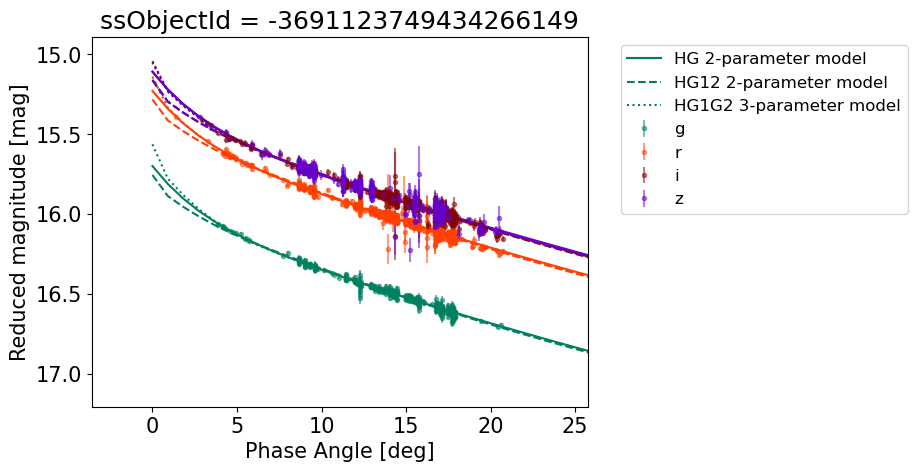

In [19]:
iObj = 100
sId = uniqueObj['ssObjectId'][iObj]
tmp = indivObs[indivObs['ssObjectId'] == sId]
phases = np.linspace(0, 90, 100)

for i, ifilt in enumerate(filts):
    idx = tmp['band'] == ifilt
    if i==0:
        labels = ['HG 2-parameter model',
                  'HG12 2-parameter model', 
                  'HG1G2 3-parameter model'
                 ]
    else:
        labels = [None, None, None]

    plt.errorbar(tmp['phaseAngle'][idx], tmp['reducedMag'][idx],
                 yerr=tmp['magErr'][idx], fmt='.',
                 color=filter_colors[ifilt], alpha=0.5, label=ifilt)

    HG_mag = HG_model(np.deg2rad(phases),
                      [results[(results.ssObjectId == sId)
                               & (results.fname == ifilt)]['HG.H'].values,
                       results[(results.ssObjectId == sId)
                               & (results.fname == ifilt)]['HG.G'].values])
    plt.plot(phases, HG_mag, color=filter_colors[ifilt],
             label=labels[0])

    HG12_mag = HG12_model(np.deg2rad(phases),
                          [results[(results.ssObjectId == sId)
                                   & (results.fname == ifilt)]['HG12.H'].values,
                           results[(results.ssObjectId == sId)
                                   & (results.fname == ifilt)]['HG12.G12'].values])
    plt.plot(phases, HG12_mag, color=filter_colors[ifilt], linestyle='--',
             label=labels[1])

    HG1G2_mag = HG1G2_model(np.deg2rad(phases),
                            [results[(results.ssObjectId == sId)
                                     & (results.fname == ifilt)]['HG1G2.H'].values,
                             results[(results.ssObjectId == sId)
                                     & (results.fname == ifilt)]['HG1G2.G1'].values,
                             results[(results.ssObjectId == sId)
                                     & (results.fname == ifilt)]['HG1G2.G2'].values])
    plt.plot(phases, HG1G2_mag, color=filter_colors[ifilt], linestyle='dotted',
             label=labels[2])

plt.xlim(tmp['phaseAngle'].min()-5, tmp['phaseAngle'].max()+5)
plt.ylim(tmp['reducedMag'].max()+0.5, tmp['reducedMag'].min()-0.5)
plt.xlabel('Phase Angle [deg]')
plt.ylabel('Reduced magnitude [mag]')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title('ssObjectId = %d' % sId)
plt.show()

## 4. Compare manually-derived phase curve parameters to those provided in DP0.3

As mentioned in Section 2.2, the DP0.3 phase curve simulations were based on the `mpcH` and `mpcG` parameters stored in the `MPCORB` table using the `HG_model`. On the other hand, the simulated LSST observations of phase curves were fitted using the `HG12_model` and the resulting `H` and `G12` parameters are stored in the `SSObject` table. This Section compares those phase curve parameters provided in the DP0.3 tables to the manually-driven parameters in this tutorial. 

### 4.1 Compare to the pipeline-provided phase curve parameters stored in the SSObject table

While modeling phase curves manually using these three fitting functions demonstrates the process, the `HG12_model` results (the parametrization that is more stable to limited observations across phase angles) will automatically be tabulated as a data product during the course of the survey in the `SSObject` table. This section will compare the manually derived parameters from the last section with those produced in LSST data products.

The figure below compares the manually-derived slope parameter `G12` for all the unique objects to the Rubin pipeline-provided values stored in the `SSObject` table in DP0.3. It is clear that overall the manual measurement recovers the DP0.3 value and uncertainty, which is expected because the `HG12` model was used to automatically fit the DP0.3 simulated data.

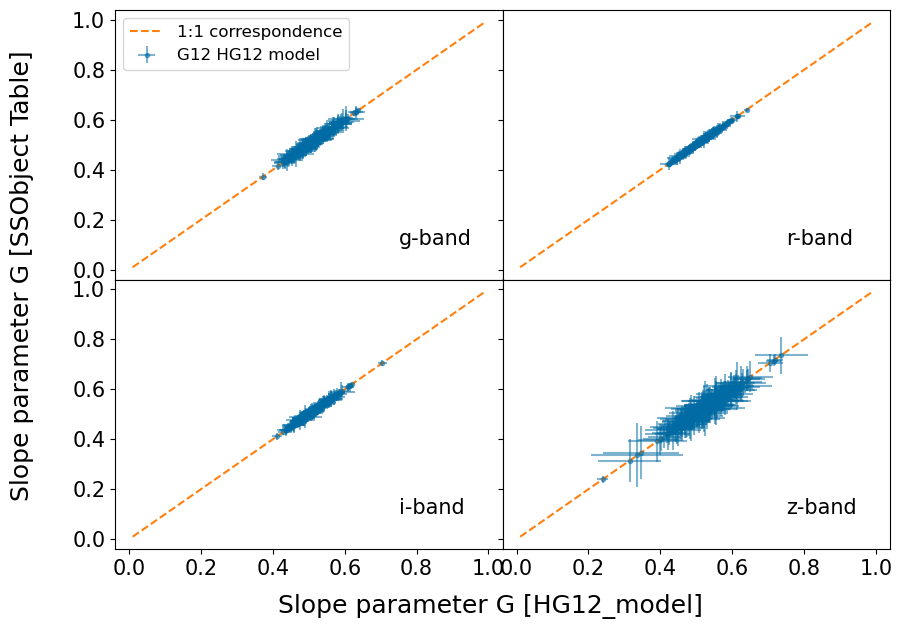

In [20]:
fig = plt.figure(figsize=(10, 7))
gs = fig.add_gridspec(2, 2, wspace=0, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
axs = axs.ravel()

one2one = np.arange(0.01, 1, .01)
filts = ['g', 'r', 'i', 'z']
for i, ifilt in enumerate(filts):

    axs[i].errorbar(results[results.fname == ifilt]['HG12.G12'],
                    uniqueObj[ifilt+'_G12'],
                    xerr=results[results.fname == ifilt]['HG12.G12_err'],
                    yerr=uniqueObj[ifilt+'_G12err'], fmt='.', alpha=0.5,
                    label='G12 HG12 model')

    axs[i].plot(one2one, one2one, '--', label='1:1 correspondence')
    axs[i].text(0.75, 0.1, ifilt+'-band')

fig.supxlabel('Slope parameter G [HG12_model]')
fig.supylabel('Slope parameter G [SSObject Table]')
axs[0].legend(loc=2)
plt.show()

The below figure compares the manually-derived absolute magnitude `H` for all the unique objects to the Rubin pipeline-provided values stored in the `SSObject` table in DP0.3. Like the G12 parameter, it is clear that overall the manual measurement recovers the DP0.3 value and uncertainty, which is expected because the `HG12` model was used to automatically fit the DP0.3 simulated data.

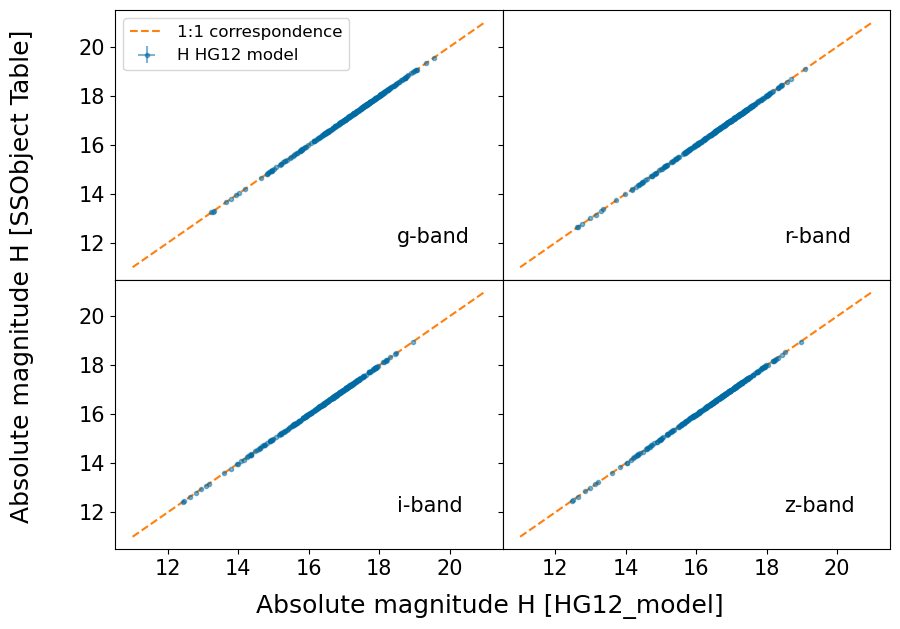

In [21]:
fig = plt.figure(figsize=(10, 7))
gs = fig.add_gridspec(2, 2, wspace=0, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
axs = axs.ravel()

one2one = np.arange(11, 22, 1)
for i, ifilt in enumerate(filts):

    axs[i].errorbar(results[results.fname == ifilt]['HG12.H'],
                    uniqueObj[ifilt+'_H'],
                    xerr=results[results.fname == ifilt]['HG12.H_err'],
                    yerr=uniqueObj[ifilt+'_Herr'], fmt='.', alpha=0.5,
                    label='H HG12 model')

    axs[i].plot(one2one, one2one, '--', label='1:1 correspondence')
    axs[i].text(18.5, 12, ifilt+'-band')

fig.supxlabel('Absolute magnitude H [HG12_model]')
fig.supylabel('Absolute magnitude H [SSObject Table]')
axs[0].legend(loc=2)
plt.show()

### 4.2 Compare to the input phase curve parameters stored in the MPCORB table

This section compares the input phase curve parameters, `mpcH` and `mpcG`, that were used to simulate asteroids in DP0.3 with those derived using the `HG_model` in this tutorial to see how well the input parameters are recovered in the simulated LSST results at the end of the 10 year survey.  The left panel shows the difference of 0.2 between the input slope `G` and the output slope `G` guided by the red solid lines in all four filters. The distributions of out-in absolute magnitude `H` are more complicated. Recall that `mpcH` is reported in $V$ band; the conversion from Rubin filters to $V$ is summarized in <a href="https://dp0-3.lsst.io/data-products-dp0-3/data-simulation-dp0-3.html#synthetic-object-populations">Table 1 of the DP0.3 documentation</a>. The filter conversion can not fully explain the offsets seen in the out-in distributions (the table of filter conversions between V-band and LSST at the link above are never more than 0.4, but the right-hand panel shows g-bad with an offset of >0.4).   

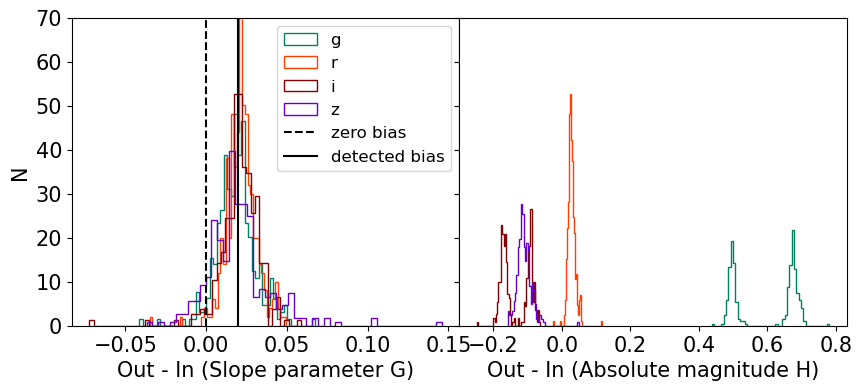

In [22]:
fig = plt.figure(figsize=(10, 4))
gs = fig.add_gridspec(1, 2, wspace=0)
axs = gs.subplots(sharey=True)
axs = axs.ravel()

one2one = np.arange(0.01, 1, .01)
for i, ifilt in enumerate(filts):

    h = axs[0].hist(results[results.fname == ifilt]['HG.G']
                    - uniqueObj['mpcG'], bins=50, density=True,
                    histtype='step', color=filter_colors[ifilt], label=ifilt)

    h = axs[1].hist(results[results.fname == ifilt]['HG.H']
                    - uniqueObj['mpcH'], bins=50, density=True,
                    histtype='step', color=filter_colors[ifilt])


axs[0].set_xlabel('Out - In (Slope parameter G)')
axs[0].set_ylabel('N')
axs[0].plot([0, 0], [0, 80], 'k--',label='zero bias')
axs[0].plot([0.02, 0.02], [0, 80], 'k',label='detected bias')
axs[0].set_ylim(0, 70)
axs[0].legend(loc=1)
axs[1].set_xlabel('Out - In (Absolute magnitude H)')
plt.show()

## 5. An incomplete list of outstanding questions about DP0.3 phase curves 
This DP0.3 release revealed some unknown features that can be resolved in the future as people use the simulation. Some things that warrant further exploration:

- A small bias (roughly 0.02 in all filters) was identified in the `G` parameter of `HG_model` (average measured value - intrinsic value of `G`).

- Offsets between the intrinsic absolute magnitude in $V$ band and recovered absolute magnitude in the LSST filters are larger than listed in the filter-conversion table referenced above.

## 6. Excercises for the learner

1. Compare the 3 fits for objects with less phase coverage (e.g., Jupiter Trojans).
2. Fit phase curves for TNOs with a linear function.
3. Apply the filter conversion in each Rubin filter and revisit the second plot in Section 4.2.